# Coursera - IBM Data Science Capstone
## Week 3 Project - Segmenting and Clustering Neighborhoods in Toronto
### Part 3 - K-Means Clustering

Import Libraries

In [68]:
import geocoder
from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from PIL import Image
from IPython.display import Image 

Load data into DataFrame using file created in Part 2

In [2]:
df = pd.read_csv('toronto-data-lat-lng.csv', usecols =["Postalcode","Borough","Neighborhood","Latitude","Longitude"])

Get the latitude and longitude coordinates for Toronto (uncomment to display a map of Toronto with neighborhoods shown)

In [3]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent='my-application')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
#map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
#for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
#    label = '{}, {}'.format(neighborhood, borough)
#    label = folium.Popup(label, parse_html=True)
#    folium.CircleMarker(
#        [lat, lng],
#        radius=2,
#        popup=label,
#        color='blue',
#        fill=True,
#        fill_color='blue',
#        fill_opacity=1.0,
#        parse_html=False).add_to(map_toronto)  
    
#map_toronto

The geograpical coordinate of Toronto are 43.653963, -79.387207.


FourSquare API parameters & credentials 

In [4]:
neighborhood_latitude = df.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[1, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))


LIMIT = 100
radius = 500
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180604'

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

Latitude and longitude values of Highland Creek, Rouge Hill, Port Union are 43.7845351, -79.16049709999999.


In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create a list of nearby venues which will be used to cluster neighborhoods into different "types"

In [6]:
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

display(nearby_venues)

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Poke Guys,Poke Place,43.654895,-79.385052
3,Rolltation,Japanese Restaurant,43.654918,-79.387424
4,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
5,Karine's,Breakfast Spot,43.653699,-79.390743
6,Manpuku まんぷく,Japanese Restaurant,43.653612,-79.390613
7,Fugo Desserts,Ice Cream Shop,43.654923,-79.387382
8,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684
9,The Library Specialty Coffee,Coffee Shop,43.654413,-79.390902


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [27]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
3,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [10]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


In [11]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

cols = list(toronto_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
toronto_onehot = toronto_onehot[['Neighborhood'] + cols]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

Grouping results by neighborhood and counting the frequency of the top venues

In [26]:
num_top_venues = 5

i=0
for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    i += 1
    if (i == 5): break

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1       Restaurant  0.05
2  Thai Restaurant  0.04
3             Café  0.04
4              Bar  0.03


----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2               Skating Rink   0.2
3             Clothing Store   0.2
4  Latin American Restaurant   0.2


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                      venue  freq
0                      Park  0.33
1                Playground  0.33
2               Coffee Shop  0.33
3         Accessories Store  0.00
4  Mediterranean Restaurant  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store   0.2
1  Fast Food Restaurant   0.1
2        Discount Store   0.1
3   Japanese Restaurant   0.1
4        Sandwich Place   0.1


----Alderwood,

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Display the top 10 venues in the list of venues

In [14]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Thai Restaurant,Café,Bar,Sushi Restaurant,Burger Joint,Seafood Restaurant,Asian Restaurant,Gym
1,Agincourt,Latin American Restaurant,Skating Rink,Breakfast Spot,Lounge,Clothing Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Coffee Shop,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Discount Store,Sandwich Place,Beer Store,Japanese Restaurant,Pizza Place,Pharmacy,Donut Shop
4,"Alderwood, Long Branch",Pizza Place,Skating Rink,Pool,Coffee Shop,Gym,Pub,Pharmacy,Sandwich Place,Deli / Bodega,Department Store


Perform K-Means Clustering

In [23]:
toronto_data = df.copy()
# set number of clusters
kclusters = 5

#print(toronto_data.shape)
#print(toronto_grouped_clustering.shape)

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([2, 2, 1, 2, 0, 2, 2, 2, 2, 2], dtype=int32)

Arrange data according to cluster labels

In [56]:
toronto_merged = toronto_data

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Display results of clustering algorithm

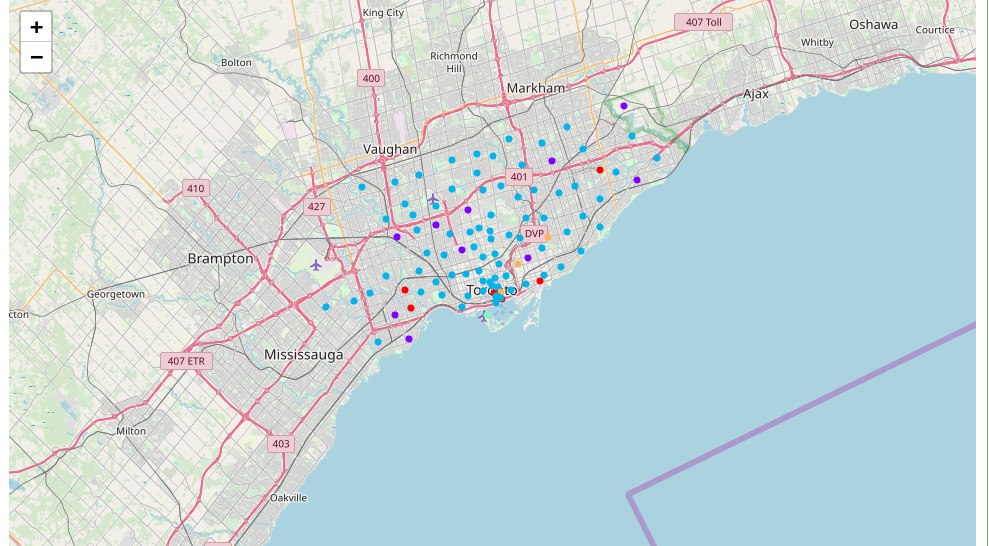

In [69]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_clusters)


pil_img = Image(filename='map_clusters.png')
display(pil_img)

### From the results of the clustering with 5 cluster centers, it seems Toronto is a rather homogenous city in terms of venue types within a given neighborhood.  The green, yellow, and red are all sparsely represented. The purple catagory has a moderate representation, while the blue clusters clearly dominate.